In [92]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
%matplotlib inline

# Random Forest on Titanic

https://towardsdatascience.com/your-first-apache-spark-ml-model-d2bb82b599dd

https://www.kaggle.com/c/titanic/notebooks

In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName('Titanic') \
    .getOrCreate()
sc = spark.sparkContext

In [2]:
df = (spark.read.format('csv')\
             .option('header', 'true')\
             .option('inferSchema', 'true')\
             .load("/demo/titanic/titanic-train.csv"))

In [3]:
df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [4]:
df.count()

891

In [5]:
from pyspark.sql.functions import col
dataset = df.select(col('Survived').cast('float'),
                         col('Pclass').cast('float'),
                         col('Sex'),
                         col('Age').cast('float'),
                         col('Fare').cast('float'),
                         col('Embarked')
                        )
dataset.show()

+--------+------+------+----+-------+--------+
|Survived|Pclass|   Sex| Age|   Fare|Embarked|
+--------+------+------+----+-------+--------+
|     0.0|   3.0|  male|22.0|   7.25|       S|
|     1.0|   1.0|female|38.0|71.2833|       C|
|     1.0|   3.0|female|26.0|  7.925|       S|
|     1.0|   1.0|female|35.0|   53.1|       S|
|     0.0|   3.0|  male|35.0|   8.05|       S|
|     0.0|   3.0|  male|null| 8.4583|       Q|
|     0.0|   1.0|  male|54.0|51.8625|       S|
|     0.0|   3.0|  male| 2.0| 21.075|       S|
|     1.0|   3.0|female|27.0|11.1333|       S|
|     1.0|   2.0|female|14.0|30.0708|       C|
|     1.0|   3.0|female| 4.0|   16.7|       S|
|     1.0|   1.0|female|58.0|  26.55|       S|
|     0.0|   3.0|  male|20.0|   8.05|       S|
|     0.0|   3.0|  male|39.0| 31.275|       S|
|     0.0|   3.0|female|14.0| 7.8542|       S|
|     1.0|   2.0|female|55.0|   16.0|       S|
|     0.0|   3.0|  male| 2.0| 29.125|       Q|
|     1.0|   2.0|  male|null|   13.0|       S|
|     0.0|   

In [6]:
from pyspark.sql.functions import isnull, when, count, col
dataset.select([count(when(isnull(c), c)).alias(c) for c in dataset.columns]).show()

+--------+------+---+---+----+--------+
|Survived|Pclass|Sex|Age|Fare|Embarked|
+--------+------+---+---+----+--------+
|       0|     0|  0|177|   0|       2|
+--------+------+---+---+----+--------+



In [7]:
dataset = dataset.replace('?', None)\
        .dropna(how='any')

In [8]:
dataset.count()

712

**A l'entrainement :**

Pseudo-code.

```
operation_gender = StringIndexer(
    inputCol='Sex', 
    outputCol='Gender', 
    handleInvalid='keep').fit(dataset_entrainement)
operation_gender.save()
dataset_entrainement = operation_gender.transform(dataset_entrainement)
```

**A la prédiction en production :**
```
operation_gender.load()
feature_production = operation_gender.transform(feature_production)
```

A retenir : il faut mémoriser les opérations de transformation pour les ré-appliquer en production.

In [9]:
from pyspark.ml.feature import StringIndexer
dataset = StringIndexer(
    inputCol='Sex', 
    outputCol='Gender', 
    handleInvalid='keep').fit(dataset).transform(dataset)
dataset = StringIndexer(
    inputCol='Embarked', 
    outputCol='Boarded', 
    handleInvalid='keep').fit(dataset).transform(dataset)
dataset.show()

+--------+------+------+----+-------+--------+------+-------+
|Survived|Pclass|   Sex| Age|   Fare|Embarked|Gender|Boarded|
+--------+------+------+----+-------+--------+------+-------+
|     0.0|   3.0|  male|22.0|   7.25|       S|   0.0|    0.0|
|     1.0|   1.0|female|38.0|71.2833|       C|   1.0|    1.0|
|     1.0|   3.0|female|26.0|  7.925|       S|   1.0|    0.0|
|     1.0|   1.0|female|35.0|   53.1|       S|   1.0|    0.0|
|     0.0|   3.0|  male|35.0|   8.05|       S|   0.0|    0.0|
|     0.0|   1.0|  male|54.0|51.8625|       S|   0.0|    0.0|
|     0.0|   3.0|  male| 2.0| 21.075|       S|   0.0|    0.0|
|     1.0|   3.0|female|27.0|11.1333|       S|   1.0|    0.0|
|     1.0|   2.0|female|14.0|30.0708|       C|   1.0|    1.0|
|     1.0|   3.0|female| 4.0|   16.7|       S|   1.0|    0.0|
|     1.0|   1.0|female|58.0|  26.55|       S|   1.0|    0.0|
|     0.0|   3.0|  male|20.0|   8.05|       S|   0.0|    0.0|
|     0.0|   3.0|  male|39.0| 31.275|       S|   0.0|    0.0|
|     0.

In [98]:
a=1
type((a,2))
dataset."fff"

tuple

In [10]:
dataset.dtypes

[('Survived', 'float'),
 ('Pclass', 'float'),
 ('Sex', 'string'),
 ('Age', 'float'),
 ('Fare', 'float'),
 ('Embarked', 'string'),
 ('Gender', 'double'),
 ('Boarded', 'double')]

In [11]:
# Drop unnecessary columns
dataset = dataset.drop('Sex')
dataset = dataset.drop('Embarked')
dataset.show()

+--------+------+----+-------+------+-------+
|Survived|Pclass| Age|   Fare|Gender|Boarded|
+--------+------+----+-------+------+-------+
|     0.0|   3.0|22.0|   7.25|   0.0|    0.0|
|     1.0|   1.0|38.0|71.2833|   1.0|    1.0|
|     1.0|   3.0|26.0|  7.925|   1.0|    0.0|
|     1.0|   1.0|35.0|   53.1|   1.0|    0.0|
|     0.0|   3.0|35.0|   8.05|   0.0|    0.0|
|     0.0|   1.0|54.0|51.8625|   0.0|    0.0|
|     0.0|   3.0| 2.0| 21.075|   0.0|    0.0|
|     1.0|   3.0|27.0|11.1333|   1.0|    0.0|
|     1.0|   2.0|14.0|30.0708|   1.0|    1.0|
|     1.0|   3.0| 4.0|   16.7|   1.0|    0.0|
|     1.0|   1.0|58.0|  26.55|   1.0|    0.0|
|     0.0|   3.0|20.0|   8.05|   0.0|    0.0|
|     0.0|   3.0|39.0| 31.275|   0.0|    0.0|
|     0.0|   3.0|14.0| 7.8542|   1.0|    0.0|
|     1.0|   2.0|55.0|   16.0|   1.0|    0.0|
|     0.0|   3.0| 2.0| 29.125|   0.0|    2.0|
|     0.0|   3.0|31.0|   18.0|   1.0|    0.0|
|     0.0|   2.0|35.0|   26.0|   0.0|    0.0|
|     1.0|   2.0|34.0|   13.0|   0

In [12]:
# Assemble all the features with VectorAssembler
required_features = ['Pclass',
                    'Age',
                    'Fare',
                    'Gender',
                    'Boarded'
                   ]
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(dataset)

In [13]:
transformed_data.show(5)

+--------+------+----+-------+------+-------+--------------------+
|Survived|Pclass| Age|   Fare|Gender|Boarded|            features|
+--------+------+----+-------+------+-------+--------------------+
|     0.0|   3.0|22.0|   7.25|   0.0|    0.0|[3.0,22.0,7.25,0....|
|     1.0|   1.0|38.0|71.2833|   1.0|    1.0|[1.0,38.0,71.2833...|
|     1.0|   3.0|26.0|  7.925|   1.0|    0.0|[3.0,26.0,7.92500...|
|     1.0|   1.0|35.0|   53.1|   1.0|    0.0|[1.0,35.0,53.0999...|
|     0.0|   3.0|35.0|   8.05|   0.0|    0.0|[3.0,35.0,8.05000...|
+--------+------+----+-------+------+-------+--------------------+
only showing top 5 rows



In [14]:
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])

In [15]:
training_data.count(), test_data.count()

(578, 134)

In [16]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol='Survived', 
                            featuresCol='features',
                            maxDepth=10)

In [71]:
??RandomForestClassifier

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Source:        
class RandomForestClassifier(ForestClassifier):
    """
    A random forest classifier.

    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control over-fitting.
    The sub-sample size is controlled with the `max_samples` parameter if
    `bootstrap=True` (default), otherwise the whole dataset is used to build
    each tree.

    Read more in the :ref:

In [17]:
model = rf.fit(training_data)

In [18]:
predictions = model.transform(test_data)

In [19]:
predictions.count()

134

In [20]:
# Evaluate our model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol='Survived', 
    predictionCol='prediction', 
    metricName='accuracy')

In [21]:
accuracy = evaluator.evaluate(predictions)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.835820895522388


In [64]:
predictions.filter(predictions.Survived > 0).show(3,50)

+--------+------+----+--------+------+-------+--------------------------------------------------+----------------------------------------+-----------------------------------------+----------+
|Survived|Pclass| Age|    Fare|Gender|Boarded|                                          features|                           rawPrediction|                              probability|prediction|
+--------+------+----+--------+------+-------+--------------------------------------------------+----------------------------------------+-----------------------------------------+----------+
|     1.0|   1.0|0.92|  151.55|   0.0|    0.0|[1.0,0.9200000166893005,151.5500030517578,0.0,0.0]|  [2.984353741496599,17.015646258503402]| [0.14921768707482994,0.8507823129251701]|       1.0|
|     1.0|   1.0| 4.0| 81.8583|   0.0|    0.0|                [1.0,4.0,81.8582992553711,0.0,0.0]|  [3.484353741496599,16.515646258503402]| [0.17421768707482993,0.8257823129251701]|       1.0|
|     1.0|   1.0|15.0|211.3375|   1.0|  

In [62]:
predictions.filter(predictions.Survived > 0).take(3)

[Row(Survived=1.0, Pclass=1.0, Age=0.9200000166893005, Fare=151.5500030517578, Gender=0.0, Boarded=0.0, features=DenseVector([1.0, 0.92, 151.55, 0.0, 0.0]), rawPrediction=DenseVector([2.9844, 17.0156]), probability=DenseVector([0.1492, 0.8508]), prediction=1.0),
 Row(Survived=1.0, Pclass=1.0, Age=4.0, Fare=81.8582992553711, Gender=0.0, Boarded=0.0, features=DenseVector([1.0, 4.0, 81.8583, 0.0, 0.0]), rawPrediction=DenseVector([3.4844, 16.5156]), probability=DenseVector([0.1742, 0.8258]), prediction=1.0),
 Row(Survived=1.0, Pclass=1.0, Age=15.0, Fare=211.33749389648438, Gender=1.0, Boarded=0.0, features=DenseVector([1.0, 15.0, 211.3375, 1.0, 0.0]), rawPrediction=DenseVector([0.0083, 19.9917]), probability=DenseVector([0.0004, 0.9996]), prediction=1.0)]

In [23]:
predictions.filter(predictions.Survived > 0).toPandas().head(3)

,Survived,Pclass,Age,Fare,Gender,Boarded,features,rawPrediction,probability,prediction
0,1.0,1.0,0.92,151.550003,0.0,0.0,"[1.0, 0.9200000166893005, 151.5500030517578, 0...","[2.984353741496599, 17.015646258503402]","[0.14921768707482994, 0.8507823129251701]",1.0
1,1.0,1.0,4.00,81.858299,0.0,0.0,"[1.0, 4.0, 81.8582992553711, 0.0, 0.0]","[3.484353741496599, 16.515646258503402]","[0.17421768707482993, 0.8257823129251701]",1.0
2,1.0,1.0,15.00,211.337494,1.0,0.0,"[1.0, 15.0, 211.33749389648438, 1.0, 0.0]","[0.008264462809917356, 19.99173553719008]","[0.00041322314049586776, 0.999586776859504]",1.0
3,1.0,1.0,16.00,57.979198,1.0,1.0,"[1.0, 16.0, 57.97919845581055, 1.0, 1.0]","[0.008264462809917356, 19.99173553719008]","[0.00041322314049586776, 0.999586776859504]",1.0
4,1.0,1.0,17.00,57.000000,1.0,0.0,"[1.0, 17.0, 57.0, 1.0, 0.0]","[0.008264462809917356, 19.99173553719008]","[0.00041322314049586776, 0.999586776859504]",1.0
5,1.0,1.0,17.00,108.900002,1.0,1.0,"[1.0, 17.0, 108.9000015258789, 1.0, 1.0]","[0.008264462809917356, 19.99173553719008]","[0.00041322314049586776, 0.999586776859504]",1.0
6,1.0,1.0,22.00,49.500000,1.0,1.0,"[1.0, 22.0, 49.5, 1.0, 1.0]","[0.008264462809917356, 19.99173553719008]","[0.00041322314049586776, 0.999586776859504]",1.0
7,1.0,1.0,22.00,151.550003,1.0,0.0,"[1.0, 22.0, 151.5500030517578, 1.0, 0.0]","[0.008264462809917356, 19.99173553719008]","[0.00041322314049586776, 0.999586776859504]",1.0
8,1.0,1.0,23.00,263.000000,1.0,0.0,"[1.0, 23.0, 263.0, 1.0, 0.0]","[0.008264462809917356, 19.99173553719008]","[0.00041322314049586776, 0.999586776859504]",1.0
9,1.0,1.0,27.00,30.500000,0.0,0.0,"[1.0, 27.0, 30.5, 0.0, 0.0]","[6.452712690196105, 13.547287309803897]","[0.32263563450980526, 0.6773643654901949]",1.0


# Metrics

## Matrice de confusion

![](https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png)

https://en.wikipedia.org/wiki/Confusion_matrix

In [24]:
dfp = predictions.toPandas()

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
cm = confusion_matrix(dfp['Survived'], dfp['prediction'], normalize=None)
cm

array([[63, 11],
       [11, 49]])

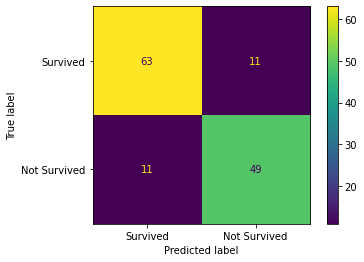

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
disp=ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=['Survived','Not Survived'])
import matplotlib.pyplot as plt
disp.plot()

- TP (True Positives) : les cas où la prédiction est positive, et où la valeur réelle est effectivement positive. Exemple : le médecin vous annonce que vous êtes enceinte, et vous êtes bel et bien enceinte.
-  TN (True Negatives) : les cas où la prédiction est négative, et où la valeur réelle est effectivement négative. Exemple : le médecin vous annonce que vous n’êtes pas enceinte, et vous n’êtes effectivement pas enceinte.
-    FP (False Positive) : les cas où la prédiction est positive, mais où la valeur réelle est négative. Exemple : le médecin vous annonce que vous êtes enceinte, mais vous n’êtes pas enceinte.
-    FN (False Negative) : les cas où la prédiction est négative, mais où la valeur réelle est positive. Exemple : le médecin vous annonce que vous n’êtes pas enceinte, mais vous êtes enceinte.

### Precision

Precision = TP / (TP+FP)

In [28]:
from sklearn.metrics import precision_score, recall_score

precision_score(dfp['Survived'], dfp['prediction'])

0.8166666666666667

In [29]:
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8166666666666667

### Recall

sensitivity, recall, hit rate, or true positive rate (TPR)

rappel = sensitivité = true positive rate TPR = TP / (TP + FN)

In [30]:
recall_score(dfp['Survived'], dfp['prediction'])

0.8166666666666667

In [31]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.8166666666666667

### F1 Score

F1 = 2x ((precision*recall)/(precision+recall))= TP / (TP+(FN+FP)/2)

In [32]:
from sklearn.metrics import f1_score
f1_score(dfp['Survived'], dfp['prediction'])

0.8166666666666667

In [33]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.8166666666666667

In [34]:
y_scores = [p[1] for p in dfp['probability']]
y_scores[:5]

[0.35017676767676764,
 0.15815410779696495,
 0.9495867768595041,
 0.6741433566433567,
 0.24137951700534627]

In [35]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(dfp['Survived'], y_scores)
y_train_5 = dfp['Survived']

In [36]:
precisions

array([0.45454545, 0.45038168, 0.45384615, 0.4609375 , 0.46456693,
       0.46825397, 0.472     , 0.47580645, 0.4796748 , 0.48760331,
       0.49579832, 0.5       , 0.5042735 , 0.50862069, 0.51304348,
       0.50877193, 0.51327434, 0.52252252, 0.52727273, 0.53211009,
       0.53703704, 0.53271028, 0.53773585, 0.54285714, 0.54807692,
       0.56435644, 0.57      , 0.57575758, 0.58163265, 0.58762887,
       0.59375   , 0.60638298, 0.61290323, 0.61956522, 0.61538462,
       0.62222222, 0.62921348, 0.63636364, 0.64367816, 0.65116279,
       0.64705882, 0.6547619 , 0.6626506 , 0.67901235, 0.675     ,
       0.6835443 , 0.67948718, 0.68831169, 0.69736842, 0.69333333,
       0.7027027 , 0.71232877, 0.72222222, 0.73239437, 0.74285714,
       0.75362319, 0.76470588, 0.7761194 , 0.78787879, 0.78461538,
       0.78125   , 0.77777778, 0.79032258, 0.80327869, 0.81666667,
       0.81355932, 0.81034483, 0.8245614 , 0.82142857, 0.83333333,
       0.8490566 , 0.86538462, 0.8627451 , 0.86      , 0.85714

In [37]:
#precisions, recalls, thresholds
len(thresholds)

103

In [38]:
import numpy as np
np.argmax(precisions >= 0.90)

85

In [39]:
thresholds[5:15]

array([0.04675202, 0.0474903 , 0.04994365, 0.0543919 , 0.06717862,
       0.06820778, 0.07050489, 0.07146975, 0.07237274, 0.07383903])

In [40]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

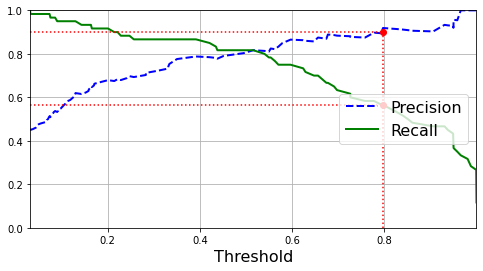

In [41]:


axmin = min(thresholds)
axmax = max(thresholds)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([axmin, axmax, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[min(len(thresholds)-1,np.argmax(precisions >= 0.90))]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([axmin, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([axmin, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

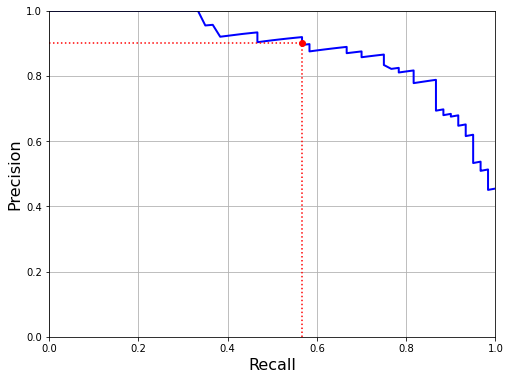

In [42]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [43]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [44]:
threshold_90_precision

0.796875

In [45]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [46]:
precision_score(y_train_5, y_train_pred_90)

0.918918918918919

In [47]:
recall_score(y_train_5, y_train_pred_90)

0.5666666666666667

# ROC curves

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=fr

https://fr.wikipedia.org/wiki/Courbe_ROC

sensitivity, recall, hit rate, or true positive rate (TPR)

sensitivité = recall = TPR

spécificité ,fall-out or false positive rate (FPR)


In [48]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

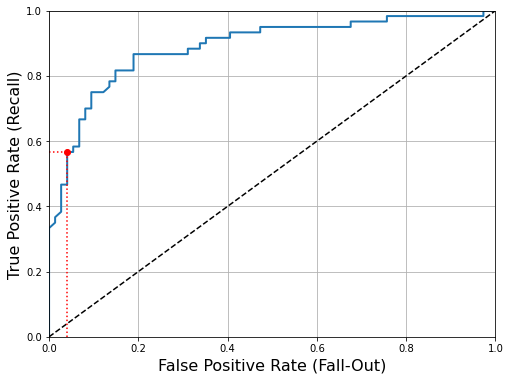

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

- À (0, 0) le classificateur déclare toujours 'négatif' : il n’y a aucun faux positif, mais également aucun vrai positif. Les proportions de vrais et faux négatifs dépendent de la population sous-jacente.
- À (1, 1) le classificateur déclare toujours 'positif' : il n’y a aucun vrai négatif, mais également aucun faux négatif. Les proportions de vrais et faux positifs dépendent de la population sous-jacente. 

## AUC
Area Under Curve

Plus proche de 1, c'est mieux

0.5 c'est très mauvais.

In [50]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.8888513513513513

## With SKLearn

**Note**: On utilise ici le jeux de données complet, ce qui est une très mauvaise pratique !

In [65]:
df_train = transformed_data.toPandas()
df_train

,Survived,Pclass,Age,Fare,Gender,Boarded,features
0,0.0,3.0,22.0,7.250000,0.0,0.0,"[3.0, 22.0, 7.25, 0.0, 0.0]"
1,1.0,1.0,38.0,71.283302,1.0,1.0,"[1.0, 38.0, 71.2833023071289, 1.0, 1.0]"
2,1.0,3.0,26.0,7.925000,1.0,0.0,"[3.0, 26.0, 7.925000190734863, 1.0, 0.0]"
3,1.0,1.0,35.0,53.099998,1.0,0.0,"[1.0, 35.0, 53.099998474121094, 1.0, 0.0]"
4,0.0,3.0,35.0,8.050000,0.0,0.0,"[3.0, 35.0, 8.050000190734863, 0.0, 0.0]"
...,...,...,...,...,...,...,...
707,0.0,3.0,39.0,29.125000,1.0,2.0,"[3.0, 39.0, 29.125, 1.0, 2.0]"
708,0.0,2.0,27.0,13.000000,0.0,0.0,"[2.0, 27.0, 13.0, 0.0, 0.0]"
709,1.0,1.0,19.0,30.000000,1.0,0.0,"[1.0, 19.0, 30.0, 1.0, 0.0]"
710,1.0,1.0,26.0,30.000000,0.0,1.0,"[1.0, 26.0, 30.0, 0.0, 1.0]"


In [66]:
X_train = df_train[['Pclass', 'Age', 'Fare','Gender', 'Boarded']].values
y_train_5 = df_train[['Survived']].values.ravel()
X_train

array([[ 3.        , 22.        ,  7.25      ,  0.        ,  0.        ],
       [ 1.        , 38.        , 71.28330231,  1.        ,  1.        ],
       [ 3.        , 26.        ,  7.92500019,  1.        ,  0.        ],
       ...,
       [ 1.        , 19.        , 30.        ,  1.        ,  0.        ],
       [ 1.        , 26.        , 30.        ,  0.        ,  1.        ],
       [ 3.        , 32.        ,  7.75      ,  0.        ,  2.        ]])

In [67]:
y_train_5[5:10]

array([0., 0., 1., 1., 1.], dtype=float32)

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [69]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

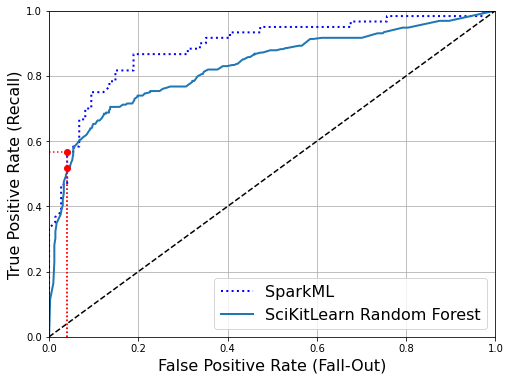

In [70]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SparkML")
plot_roc_curve(fpr_forest, tpr_forest, "SciKitLearn Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [57]:
roc_auc_score(y_train_5, y_scores_forest)

0.8289439203354297

In [58]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.7689393939393939

In [59]:
recall_score(y_train_5, y_train_pred_forest)

0.7048611111111112

# Biais / Variance

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# Split into train & test set

train = df_train[['Pclass', 'Age', 'Fare','Gender', 'Boarded']].values
target = df_train[['Survived']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(train,target, test_size = 0.2)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

KNeighborsClassifier()

In [123]:
precision_score(y_train, y_pred_train)

0.7461139896373057

In [124]:
precision_score(y_test, y_pred_test)

0.6470588235294118

Le **biais** est l'erreur provenant d’hypothèses erronées dans l'algorithme d'apprentissage. Un biais élevé peut être lié à un algorithme qui manque de relations pertinentes entre les données en entrée et les sorties prévues (**sous-apprentissage**).
    
La **variance est** l'erreur due à la sensibilité aux petites fluctuations de l’échantillon d'apprentissage. Une variance élevée peut entraîner un **surapprentissage**, c'est-à-dire modéliser le bruit aléatoire des données d'apprentissage plutôt que les sorties prévues.

https://fr.wikipedia.org/wiki/Dilemme_biais-variance

# L'explicabilité

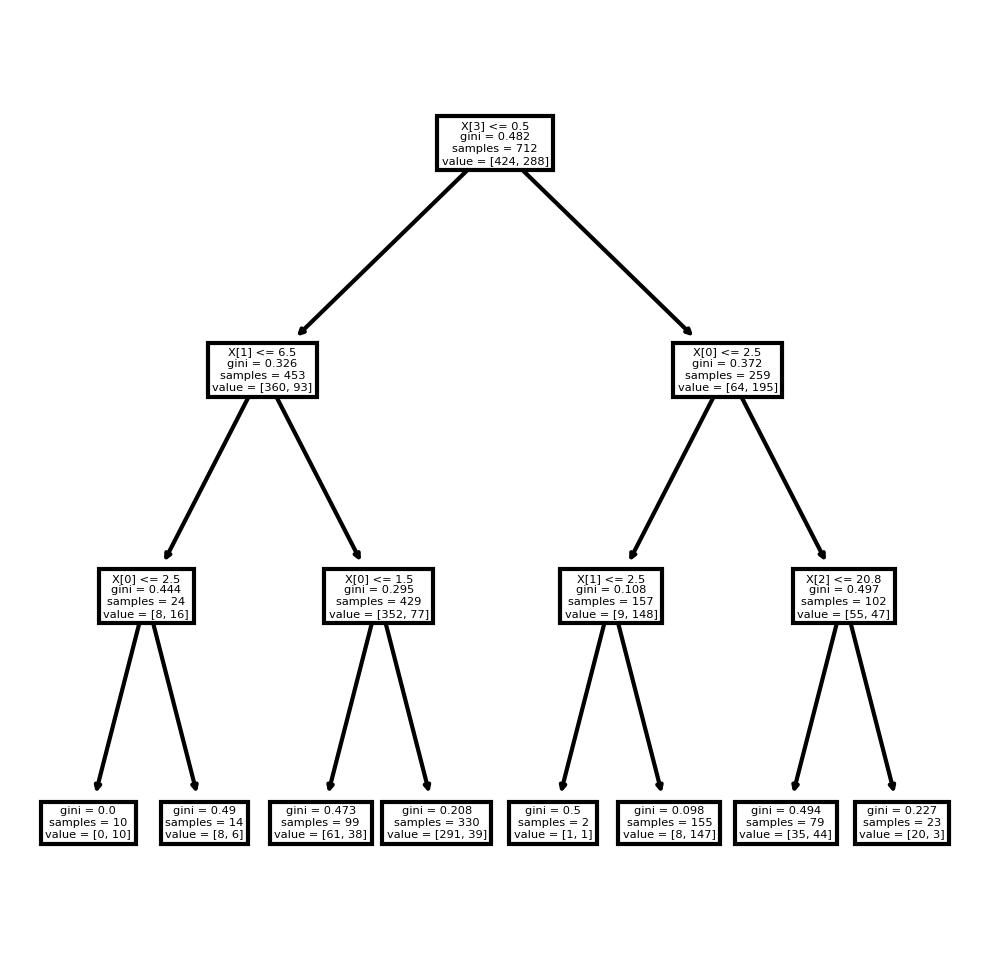

In [60]:
#import graphviz
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf = DecisionTreeClassifier(max_depth = 3)
dt = clf.fit(X_train, y_train_5)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
_ = plot_tree(dt) # , feature_names=['Pclass', 'Age', 'Fare','Gender', 'Boarded']

In [126]:
sc.stop()

In [99]:
df_train

,Survived,Pclass,Age,Fare,Gender,Boarded,features
0,0.0,3.0,22.0,7.250000,0.0,0.0,"[3.0, 22.0, 7.25, 0.0, 0.0]"
1,1.0,1.0,38.0,71.283302,1.0,1.0,"[1.0, 38.0, 71.2833023071289, 1.0, 1.0]"
2,1.0,3.0,26.0,7.925000,1.0,0.0,"[3.0, 26.0, 7.925000190734863, 1.0, 0.0]"
3,1.0,1.0,35.0,53.099998,1.0,0.0,"[1.0, 35.0, 53.099998474121094, 1.0, 0.0]"
4,0.0,3.0,35.0,8.050000,0.0,0.0,"[3.0, 35.0, 8.050000190734863, 0.0, 0.0]"
...,...,...,...,...,...,...,...
707,0.0,3.0,39.0,29.125000,1.0,2.0,"[3.0, 39.0, 29.125, 1.0, 2.0]"
708,0.0,2.0,27.0,13.000000,0.0,0.0,"[2.0, 27.0, 13.0, 0.0, 0.0]"
709,1.0,1.0,19.0,30.000000,1.0,0.0,"[1.0, 19.0, 30.0, 1.0, 0.0]"
710,1.0,1.0,26.0,30.000000,0.0,1.0,"[1.0, 26.0, 30.0, 0.0, 1.0]"


In [100]:
df_train["Age"]

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
707    39.0
708    27.0
709    19.0
710    26.0
711    32.0
Name: Age, Length: 712, dtype: float32

In [101]:
df_train[["Age"]]

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
...,...
707,39.0
708,27.0
709,19.0
710,26.0


In [102]:
df_train.Age

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
707    39.0
708    27.0
709    19.0
710    26.0
711    32.0
Name: Age, Length: 712, dtype: float32

In [108]:
df_train[["Age", "Survived"]]

,Age,Survived
0,22.0,0.0
1,38.0,1.0
2,26.0,1.0
3,35.0,1.0
4,35.0,0.0
...,...,...
707,39.0,0.0
708,27.0,0.0
709,19.0,1.0
710,26.0,1.0


In [111]:
df_train["Test"] = df_train["Age"]

In [112]:
df_train

,Survived,Pclass,Age,Fare,Gender,Boarded,features,Test
0,0.0,3.0,22.0,7.250000,0.0,0.0,"[3.0, 22.0, 7.25, 0.0, 0.0]",22.0
1,1.0,1.0,38.0,71.283302,1.0,1.0,"[1.0, 38.0, 71.2833023071289, 1.0, 1.0]",38.0
2,1.0,3.0,26.0,7.925000,1.0,0.0,"[3.0, 26.0, 7.925000190734863, 1.0, 0.0]",26.0
3,1.0,1.0,35.0,53.099998,1.0,0.0,"[1.0, 35.0, 53.099998474121094, 1.0, 0.0]",35.0
4,0.0,3.0,35.0,8.050000,0.0,0.0,"[3.0, 35.0, 8.050000190734863, 0.0, 0.0]",35.0
...,...,...,...,...,...,...,...,...
707,0.0,3.0,39.0,29.125000,1.0,2.0,"[3.0, 39.0, 29.125, 1.0, 2.0]",39.0
708,0.0,2.0,27.0,13.000000,0.0,0.0,"[2.0, 27.0, 13.0, 0.0, 0.0]",27.0
709,1.0,1.0,19.0,30.000000,1.0,0.0,"[1.0, 19.0, 30.0, 1.0, 0.0]",19.0
710,1.0,1.0,26.0,30.000000,0.0,1.0,"[1.0, 26.0, 30.0, 0.0, 1.0]",26.0
